## Validation Exercise 
In this notebook, we showcase the steps for validating EO products using cloud analytics products, particularly leveraging the Copernicus Dataspace Ecosystem OpenEO backend.

#### Login

In [1]:
# platform libraries
import openeo

# utility libraries
from datetime import date
import numpy as np
import xarray as xr
import rioxarray
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import leafmap.foliumap as leafmap

In [2]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/').authenticate_oidc()

Authenticated using refresh token.


In [3]:
catchment_outline = gpd.read_file('data/catchment_outline.geojson')

In [14]:
bbox = catchment_outline.bounds.iloc[0]
bbox

minx    11.020833
miny    46.653599
maxx    11.366667
maxy    46.954167
Name: 0, dtype: float64

Visualize the catchment of interest

In [4]:
center = (float(catchment_outline.centroid.y), float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('data/catchment_outline.geojson', layer_name="catchment")
m

### Load Snow Station Datasets

In [5]:
# utility functions for pre-processing in-situ snow station datasets
def snow_stations_format(station_daily_df, station_meta_df, start_date='2018-02-10', end_date='2018-06-30'):
    # merge and filter to get lon/lat and start and end date
    full_station_df = pd.merge(station_daily_df,
                            station_meta_df,
                            how="inner",
                            on=["Provider", "Name"]
                           ).set_index(station_daily_df.Date)
    
    full_station_df = full_station_df.drop(["HN_year_start", "HN_year_end", "HS_year_start", "HS_year_end"], axis=1)
    # full_station = full_station.reset_index(drop=True)
    full_station_df = full_station_df.sort_index(ascending=True)
    full_station_df = full_station_df.loc[start_date:end_date]
    # full_station_df = full_station_df.reset_index(drop=True)
    
    # convert lat/long to geometries
    snow_stations = gpd.GeoDataFrame(
        full_station_df,
        geometry=gpd.points_from_xy(full_station_df.Longitude, full_station_df.Latitude),
        crs="EPSG:4326"
    )
    return snow_stations

def filter_station(snow_stations, catchment_area):
    # select stations within catchment area
    catchment_stations = gpd.sjoin(snow_stations, catchment_area, op='within')
    
    # remove unneccessary columns
    station_columns = ['Provider', 'Name', 'Date', 'HN', 'HS', 'HN_after_qc', 'HS_after_qc',
       'HS_after_gapfill', 'Longitude', 'Latitude', 'Elevation', 'geometry']
    catchment_stations = catchment_stations[station_columns]
    return catchment_stations

def binarize_snow(df):
    # binarize snow presence at station level. 
    '''
    0:: implies no snow
    1:: implies snow presence
    '''
    
    if df["HS_after_gapfill"] > 0:
        return 1
    elif df["HS_after_gapfill"] <= 0:
        return 0
    else:
        return 0

In [6]:
# load snow station datasets from zenodo:: https://zenodo.org/record/5109574
station_df = pd.read_csv("data/data_daily_IT_BZ.csv") #, sep=',', index_col='Date', parse_dates=True)
station_df_meta = pd.read_csv("data/meta_all.csv")

station_df.head()

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill
0,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-01,NaN,NaN,NaN,NaN,19.0
1,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-02,NaN,NaN,NaN,NaN,18.0
2,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-03,NaN,NaN,NaN,NaN,18.0
3,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-04,NaN,NaN,NaN,NaN,18.0
4,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-05,NaN,NaN,NaN,NaN,17.0


In [7]:
snow_stations = snow_stations_format(station_df, station_df_meta)
catchment_stations = filter_station(snow_stations, catchment_outline)
catchment_stations = catchment_stations.assign(snow_presence=catchment_stations.apply(binarize_snow, axis=1))
catchment_stations.head()

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry,snow_presence
Date,,,,,,,,,,,,,
2018-02-10,IT_BZ,S_Leonardo_in_Passiria_Osservatore,2018-02-10,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906),0
2018-02-10,IT_BZ,Rifiano_Beobachter,2018-02-10,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503),0
2018-02-10,IT_BZ,Plata_Osservatore,2018-02-10,2.0,58.0,2.0,58.0,58.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),1
2018-02-10,IT_BZ,S_Martino_in_Passiria_Osservatore,2018-02-10,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268),0
2018-02-10,IT_BZ,Scena_Osservatore,2018-02-10,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960),0


In [8]:
print("There are", len(np.unique(catchment_stations.Name)), "unique stations within our catchment area of interest")

There are 5 unique stations within our catchment area of interest


<Axes: >

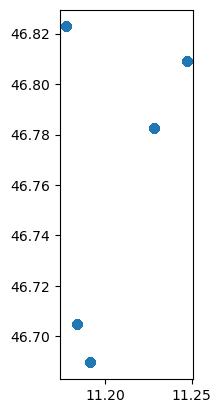

In [9]:
catchment_stations.plot()

In [10]:
# save snow stations datasets as GeoJSON in the shared folder
with open("data/catchment_stations.geojson", "w") as file:
    file.write(catchment_stations.to_json())

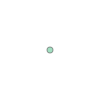

In [11]:
catchment_stations = gpd.read_file('data/catchment_stations.geojson')
catchment_stations['geometry'][0]

In [13]:
# catchment_stations["geometry"] #to_json()

### Create Process graph
- Here we recreate the process graph for computing the snow coverage area in our catchment. 

In [12]:
conn.describe_collection("SENTINEL2_L2A")

{'assets': {'thumbnail': {'href': 'https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/07/tallinn_estonia/24383281-1-eng-GB/Tallinn_Estonia_pillars.jpg',
   'roles': ['thumbnail'],
   'title': 'Sentinel 2 L2A',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'WVP',
    'AOT',
    'SCL',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean']},
  't': {'extent': ['2015-07-04T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': 'SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.\n The level 2A data is atmospherically corrected using Sen2Cor.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license',
   'type': 'application/pdf'},
  {'href': 'https://documentation.dataspace.copernicus.eu/Data/Sentinel2.html',
   'rel': 'alternate',
   'type': 'application/html'},
  {'href': 'https://dataspace.copernicus.eu/browser/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F28b654e7-8912-4e59-9e58-85b58d768b3a&datasetId=S2_L2A_CDAS&fromTime=2023-02-07T00%3A00%3A00.000Z&toTime=

In [13]:
# check for available processes in the Copernicus Dataspace backend
conn.list_processes()

[{'categories': ['arrays'],
  'description': 'Applies a process to each individual value in the array. This is basically what other languages call either a `for each` loop or a `map` function.',
  'id': 'array_apply',
  'links': [{'href': 'https://processes.openeo.org/1.2.0/examples/array_find_nodata.json',
    'rel': 'example',
    'title': 'Find no-data values in arrays',
    'type': 'application/json'},
   {'href': 'https://processes.openeo.org/1.2.0/examples/array_contains_nodata.json',
    'rel': 'example',
    'title': 'Check for no-data values in arrays',
    'type': 'application/json'}],
  'parameters': [{'description': 'An array.',
    'name': 'data',
    'schema': {'items': {'description': 'Any data type is allowed.'},
     'type': 'array'}},
   {'description': 'A process that accepts and returns a single value and is applied on each individual value in the array. The process may consist of multiple sub-processes and could, for example, consist of processes such as ``abs()`` or ``linear_scale_range()``.',
    'name': 'process',
    'schema': {'parameters': [{'description': 'The value of the current element being processed.',
       'name': 'x',
       'schema': {'description': 'Any data type.'}},
      {'description': 'The zero-based index of the current element being processed.',
       'name': 'index',
       'schema': {'minimum': 0, 'type': 'integer'}},
      {'default': None,
       'description': 'The label of the current element being processed. Only populated for labeled arrays.',
       'name': 'label',
       'optional': True,
       'schema': [{'type': 'number'}, {'type': 'string'}, {'type': 'null'}]},
      {'default': None,
       'description': 'Additional data passed by the user.',
       'name': 'context',
       'optional': True,
       'schema': {'description': 'Any data type.'}}],
     'returns': {'description': 'The value to be set in the new array.',
      'schema': {'description': 'Any data type.'}},
     'subtype': 'process-graph',
     'type': 'object'}},
   {'default': None,
    'description': 'Additional data to be passed to the process.',
    'name': 'context',
    'optional': True,
    'schema': {'description': 'Any data type.'}}],
  'returns': {'description': 'An array with the newly computed values. The number of elements are the same as for the original array.',
   'schema': {'items': {'description': 'Any data type is allowed.'},
    'type': 'array'}},
  'summary': 'Apply a process to each array element'},
 {'categories': ['math > trigonometric'],
  'description': 'Computes the arc cosine of `x`. The arc cosine is the inverse function of the cosine so that *`arccos(cos(x)) = x`*.\n\nWorks on radians only.\nThe no-data value `null` is passed through and therefore gets propagated.',
  'examples': [{'arguments': {'x': 1}, 'returns': 0}],
  'id': 'arccos',
  'links': [{'href': 'http://mathworld.wolfram.com/InverseCosine.html',
    'rel': 'about',
    'title': 'Inverse cosine explained by Wolfram MathWorld'}],
  'parameters': [{'description': 'A number.',
    'name': 'x',
    'schema': {'type': ['number', 'null']}}],
  'returns': {'description': 'The computed angle in radians.',
   'schema': {'type': ['number', 'null']}},
  'summary': 'Inverse cosine'},
 {'categories': ['math > trigonometric'],
  'description': 'Computes the inverse hyperbolic cosine of `x`. It is the inverse function of the hyperbolic cosine so that *`arcosh(cosh(x)) = x`*.\n\nWorks on radians only.\nThe no-data value `null` is passed through and therefore gets propagated.',
  'examples': [{'arguments': {'x': 1}, 'returns': 0}],
  'id': 'arcosh',
  'links': [{'href': 'http://mathworld.wolfram.com/InverseHyperbolicCosine.html',
    'rel': 'about',
    'title': 'Inverse hyperbolic cosine explained by Wolfram MathWorld'}],
  'parameters': [{'description': 'A number.',
    'name': 'x',
    'schema': {'type': ['number', 'null']}}],
  'returns': {'description': 'The computed angle in radians.',
   'schema': {'type': ['number', 'nu

In [15]:
collection      = 'SENTINEL2_L2A'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':4326}
temporal_extent = ['2018-02-10', '2018-06-30']
bands           = ['B03', 'B11', 'SCL']

In [16]:
s2 = conn.load_collection(collection,
                          spatial_extent=spatial_extent, # put json here
                          bands=bands,
                          temporal_extent=temporal_extent)
s2

In [17]:
green = s2.band("B03")
swir = s2.band("B11")
ndsi = (green - swir) / (green + swir)
ndsi

In [18]:
snowmap = ( ndsi > 0.4 ) * 1.0
snowmap

In [19]:
scl_band = s2.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0
cloud_mask

In [20]:
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2) # replacement is null by default
snowmap_cloudfree

In [21]:
# aggregate data per station points
# NOTE: Currently generates an invalidate dataset since aggregate spatial works a zonal statistics for polygons rather than point datasets
# TODO: convert each station to a cyclical or hexadrical polygon as a buffer of a set distance across them across time and aggregate again. 
snowmap_cloudfree_1d = snowmap_cloudfree.aggregate_spatial(catchment_stations['geometry'][0], reducer="mean")

In [29]:
# filter to the exact outline of the catchment: this should mask out the pixels outside of the catchment. The process are doing this not correctly. They base the masking on chunks.
# snowmap_cloudfree_masked = snowmap_cloudfree.mask_polygon(catchment_outline['geometry'][0])

In [38]:
# snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2018-02-10', '2018-06-30')
# snowmap_cloudfree_1d.download('data/snowmap_cloudfree_1d.tif')

In [39]:
# rioxarray.open_rasterio('data/snowmap_cloudfree_1d.tif')

In [40]:
# xr.open_dataarray('data/snowmap_cloudfree_1d.nc',decode_coords="all", engine='netcdf4')[0].plot.imshow()